In [23]:
from transformers import EncoderDecoderModel, AutoTokenizer, GenerationConfig
import torch
import pandas as pd
from adapters import init
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [5]:
# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")


device: cuda


In [6]:
def initialize_model_and_tokenizer(model_path, tokenizer_path, adapter_path, generation_config_path, device, adapter_name):
    """
    Initialize the model, tokenizer, and generation configuration.
    
    Args:
        model_path (str): Path to the model.
        tokenizer_path (str): Path to the tokenizer.
        adapter_path (str): Path to the adapter.
        generation_config_path (str): Path to the generation configuration.
        device (torch.device): Device to run the model on.
    
    Returns:
        model (EncoderDecoderModel): Initialized model.
        tokenizer (AutoTokenizer): Initialized tokenizer.
        generation_config (GenerationConfig): Generation configuration.
    """
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    model = EncoderDecoderModel.from_pretrained(model_path)
    model.to(device)
    init(model)
    print(f"model is on device: {model.device}")
    #model.to(device)
    model.load_adapter(adapter_path)
    model.set_active_adapters(adapter_name)
    generation_config = GenerationConfig.from_pretrained(generation_config_path)
    
    return model, tokenizer, generation_config

In [7]:
#################################### heavy2light with adapters ################################################
# model heavy2light run name: save_adapter_FULL_data_temperature_0.5_tests_max_length_150_early_stopping_true_heavy2light_with_adapters_batch_size_64_epochs_40_lr_0.0001_weight_decay_0.1
run_name = "save_adapter_FULL_data_temperature_0.5_tests_max_length_150_early_stopping_true_heavy2light_with_adapters_batch_size_64_epochs_40_lr_0.0001_weight_decay_0.1"
model_path = "/ibmm_data2/oas_database/paired_lea_tmp/paired_model/BERT2BERT/heavy2light_model_checkpoints/save_adapter_FULL_data_temperature_0.5"
tokenizer_path = f"{model_path}/checkpoint-336040"
adapter_path = f"{model_path}/final_adapter"
generation_config_path = "/ibmm_data2/oas_database/paired_lea_tmp/paired_model/BERT2BERT/heavy2light_model_checkpoints/save_adapter_FULL_data_temperature_0.5"
adapter_name = "heavy2light_adapter"

model, tokenizer, generation_config = initialize_model_and_tokenizer(model_path, tokenizer_path, adapter_path, generation_config_path, device, adapter_name)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Overwriting existing adapter 'heavy2light_adapter'.


model is on device: cuda:0


In [11]:
def load_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(line.strip())
    sequences = []
    for entry in data:
        split_entry = entry.split(' [SEP] ')
        if len(split_entry) == 2:
            sequences.append(split_entry)
        else:
            print(f"Skipping invalid entry: {entry}")
    df = pd.DataFrame(sequences, columns=['heavy', 'light'])
    return df



In [17]:
# Load small test data
test_file_path = '/ibmm_data2/oas_database/paired_lea_tmp/paired_model/train_test_val_datasets/heavy_sep_light_seq/paired_full_seqs_sep_test_no_ids_space_separated_SMALL.txt'

# load FULL test data
#test_file_path = "/ibmm_data2/oas_database/paired_lea_tmp/paired_model/train_test_val_datasets/heavy_sep_light_seq/paired_full_seqs_sep_test_no_ids_space_separated.txt"

test_df = load_data(test_file_path)
heavy_sequences = test_df["heavy"].tolist()

In [18]:
# Function to extract embeddings from the last layer
def get_last_layer_embeddings(model, tokenizer, sequences, device):
    embeddings = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for seq in sequences:
            inputs = tokenizer(seq, return_tensors="pt", padding="max_length", truncation=True, max_length=512).to(device)
            outputs = model.encoder(**inputs)
            last_hidden_states = outputs.last_hidden_state
            embeddings.append(last_hidden_states.cpu().numpy())
    return embeddings

In [19]:
# Get embeddings from the last layer
embeddings = get_last_layer_embeddings(model, tokenizer, heavy_sequences, device)
embeddings = [emb.mean(axis=1).squeeze() for emb in embeddings]  # Mean pooling


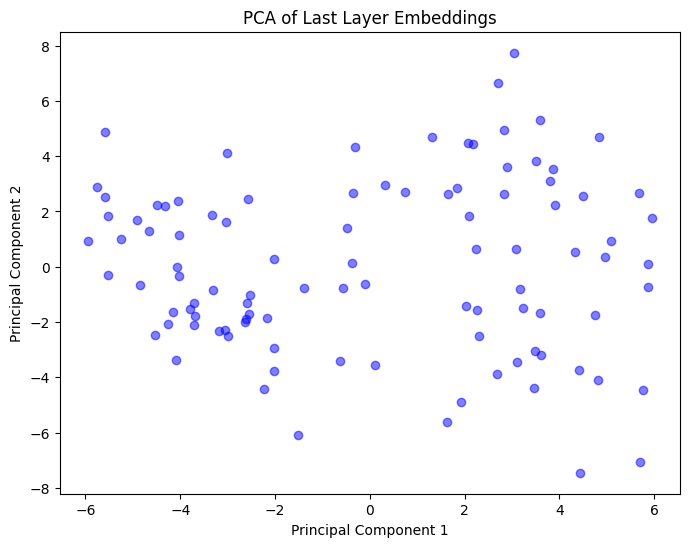

In [22]:

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# Plot PCA result
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', alpha=0.5)
plt.title('PCA of Last Layer Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


device: cuda


Overwriting existing adapter 'heavy2light_adapter'.


model is on device: cuda:0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


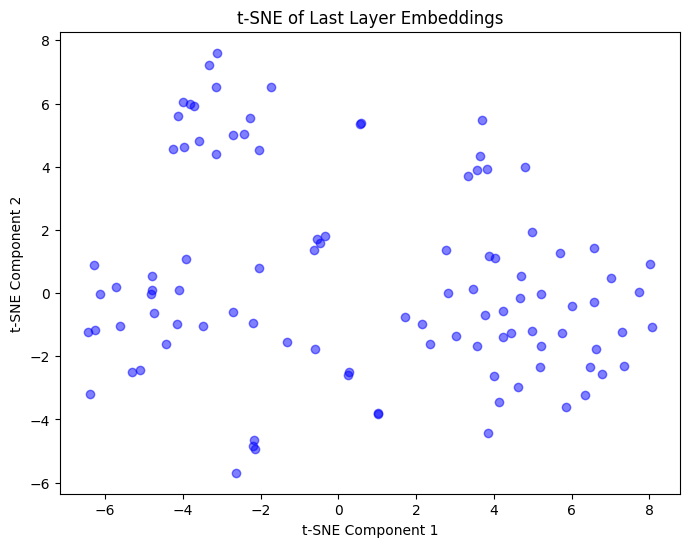

In [30]:
from transformers import EncoderDecoderModel, AutoTokenizer, GenerationConfig
import torch
import pandas as pd
from adapters import init
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

# Initialize the model, tokenizer, and generation configuration
def initialize_model_and_tokenizer(model_path, tokenizer_path, adapter_path, generation_config_path, device, adapter_name):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    model = EncoderDecoderModel.from_pretrained(model_path)
    model.to(device)
    init(model)
    print(f"model is on device: {model.device}")
    model.load_adapter(adapter_path)
    model.set_active_adapters(adapter_name)
    generation_config = GenerationConfig.from_pretrained(generation_config_path)
    return model, tokenizer, generation_config

# Define paths
model_path = "/ibmm_data2/oas_database/paired_lea_tmp/paired_model/BERT2BERT/heavy2light_model_checkpoints/save_adapter_FULL_data_temperature_0.5"
tokenizer_path = f"{model_path}/checkpoint-336040"
adapter_path = f"{model_path}/final_adapter"
generation_config_path = "/ibmm_data2/oas_database/paired_lea_tmp/paired_model/BERT2BERT/heavy2light_model_checkpoints/save_adapter_FULL_data_temperature_0.5"
adapter_name = "heavy2light_adapter"

# Initialize model and tokenizer
model, tokenizer, generation_config = initialize_model_and_tokenizer(model_path, tokenizer_path, adapter_path, generation_config_path, device, adapter_name)

# Load test data
test_file_path = '/ibmm_data2/oas_database/paired_lea_tmp/paired_model/train_test_val_datasets/heavy_sep_light_seq/paired_full_seqs_sep_test_no_ids_space_separated_SMALL.txt'

def load_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(line.strip())
    sequences = []
    for entry in data:
        split_entry = entry.split(' [SEP] ')
        if len(split_entry) == 2:
            sequences.append(split_entry)
        else:
            print(f"Skipping invalid entry: {entry}")
    df = pd.DataFrame(sequences, columns=['heavy', 'light'])
    return df

test_df = load_data(test_file_path)
heavy_sequences = test_df["heavy"].tolist()

# Function to extract embeddings from the last layer
def get_last_layer_embeddings(model, tokenizer, sequences, device):
    embeddings = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for seq in sequences:
            inputs = tokenizer(seq, return_tensors="pt", padding="max_length", truncation=True, max_length=512).to(device)
            outputs = model.encoder(**inputs)
            last_hidden_states = outputs.last_hidden_state
            embeddings.append(last_hidden_states.mean(dim=1).cpu().numpy())  # Mean pooling
    return np.vstack(embeddings)  # Stack into a numpy array

# Get embeddings from the last layer
embeddings = get_last_layer_embeddings(model, tokenizer, heavy_sequences, device)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Plot t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='blue', alpha=0.5)
plt.title('t-SNE of Last Layer Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()